## Importing libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import imageio

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Build data loading functions

In [3]:
# import gdown
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [4]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [33]:
vocab = [x for x in 'abcdefghijklmnopqrstuvwxyz?!123456789 ']
print(vocab)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']


In [6]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(),
                                           oov_token="",
                                           invert=True
                                          )

print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()} )")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =39 )


In [7]:
char_to_num(['a', 'd', 'e', 'g'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 4, 5, 7], dtype=int64)>

In [8]:
num_to_char([1, 4, 5, 7])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'd', b'e', b'g'], dtype=object)>

In [9]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    print('path', path)
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [11]:
path = ".\\data\\s1\\bbaf2n.mpg"

In [12]:
tf.convert_to_tensor(path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

''

In [13]:
frames, alignments = load_data(tf.convert_to_tensor(path))

path .\data\s1\bbaf2n.mpg


In [14]:
frames[38]

<tf.Tensor: shape=(46, 140, 1), dtype=float32, numpy=
array([[[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.29983324],
        [0.3373124 ]],

       [[1.4991663 ],
        [1.4991663 ],
        [1.4991663 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       [[1.4616871 ],
        [1.4616871 ],
        [1.4242079 ],
        ...,
        [0.3373124 ],
        [0.3373124 ],
        [0.3373124 ]],

       ...,

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [0.        ],
        [9.557184  ]],

       [[0.97445804],
        [0.97445804],
        [0.97445804],
        ...,
        [0.        ],
        [9.557184  ],
        [9.557184  ]]], dtype=float32)>

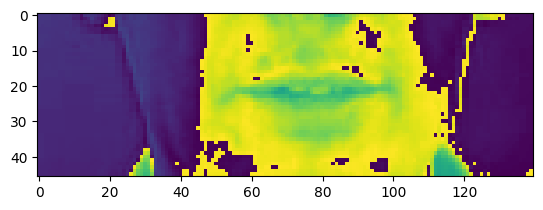

In [15]:
plt.imshow(frames[38])

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 38,  2, 12, 21,  5, 38,  1, 20, 38,  6, 38, 20, 23, 15,
       38, 14, 15, 23], dtype=int64)>

In [17]:
tf.strings.reduce_join(([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [18]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipeline

In [19]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [20]:
frames, alignment = data.as_numpy_iterator().next()

path .\data\s1\lgil4n.mpg
path .\data\s1\pbwdzp.mpg
path .\data\s1\sbig7a.mpg


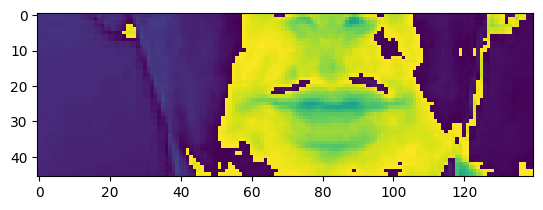

In [21]:
plt.imshow(frames[0][40])

In [22]:
alignment

array([[12,  1, 25, 38,  7, 18,  5,  5, 14, 38,  9, 14, 38, 12, 38,  6,
        15, 21, 18, 38, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 38,  2, 12, 21,  5, 38, 23,  9, 20,  8, 38,
         4, 38, 26,  5, 18, 15, 38, 16, 12,  5,  1, 19,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [23]:
test = data.as_numpy_iterator()
val = test.next()

path .\data\s1\sgac5a.mpg
path .\data\s1\sgic1a.mpg
path .\data\s1\bbws9s.mpg


In [27]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8501615524292]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.8

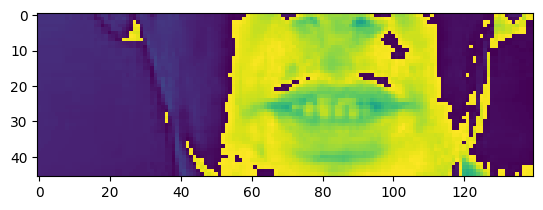

In [28]:
plt.imshow(val[0][1][40])

In [29]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green at c five again'>

## Design the Deep Neural Network

In [31]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [42]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [47]:
y_hat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in y_hat[1]])

1/1 [==============================] - 1s 695ms/step


<tf.Tensor: shape=(), dtype=string, numpy=b'ccccccccccccccccchhhhhhhhhccccccccccchhhhhhhhhhhhccccccccccccccccccccccchhh'>

In [48]:
model.input_shape

(None, 75, 46, 140, 1)

In [49]:
model.output_shape

(None, 75, 40)

## Setup Training options and Train

In [50]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backed.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss